<a href="https://colab.research.google.com/github/HamzaKamranKhawaja/ai-internship/blob/main/UNIQUIFY_ASSIGNMENT_1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import copy
from numpy.core.fromnumeric import argmax
from operator import itemgetter

# MODEL


In [2]:
#Obtain model previously configured
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/single_mnist')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 48)                6192      
                                                                 
 dense_14 (Dense)            (None, 10)                490       
                                                                 
Total params: 107,162
Trainable params: 107,162
Non-trainable params: 0
_________________________________________________________________


In [4]:
 #creating discriminator/feeder model fully connected nn with 10 output nodes
model_feeder = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(48, activation='relu'),
  tf.keras.layers.Dense(2)
])

#compile model
#loss function defined as categorical cross entropy i.e - summation(y_i_truth * log y_i_prediction) for all i
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_feeder.compile(
    optimizer='adam',
    loss=loss_function, 
    metrics=['accuracy'])


## FUNCTIONS/ HELPER FUNCTIONS

In [5]:
def black_img(array, size=(28, 28)):
  '''returns a black background image. 
  PARAM: array: An image array
  REUTRNS: an empty image array. all pixel values = 0'''
  return np.zeros((size))


def shift(arr, num, fill_value=0, axis=0):
    arr = np.roll(arr,num, axis=axis)
    if num < 0:
      if not axis: 
        arr[num:, :] = fill_value
        #arr[num:] = fill_value
      else: 
        arr[:, num:] = fill_value
    elif num > 0:
      if not axis: 
        arr[:num, ] = fill_value
      else:  
        #arr[:num] = fill_value
        arr[:, :num] = fill_value
    return arr


def destructive_crop(array, size=(28, 28), axis=0): 
  '''severely and destructively crops the image and places it 
  at a boundary edge/corner. 
  PARAM: array: An image array
        size: The shape of array. 
  RETURNS: cropped_array: The cropped and readjusted cropped array. 
  '''
  shift_amt = np.random.randint(size[0] // 2 , size[0] // 4 * 3)
  shift_direction = np.random.choice([1, -1])
  shift_amt  *= shift_direction
  shift_axis = np.random.choice([0, 1])

  rarray = shift(array, shift_amt, 0, shift_axis)
  return rarray

#functions to create evaluation dataset containing larger images of 40 * 40

def larger_destructive_crop(digit_arr, size=(40, 40)):
  '''Destructively crops the digit_arr provided.
  PARAMS: digit_arr: The digit array to be cropped.
          size: The tuple size of the desired output image. 
          
  RETURN: cropped_arr: The cropped array of size SIZE.
  '''
  cropped_arr = destructive_crop(digit_arr)
  if size[0] > 28:
    empty = np.zeros(size)
    cropped_arr, _ = fit_image(empty, cropped_arr)
  return np.array(cropped_arr)

def fit_image(arr, *digits, size=(28, 28)):
  '''Fit the given digit/digits into the arr off center and return the tranformed array. 
  PARAMS:  arr: The larger array to be fitted into. 
          *digits: variable digits list to fit. 
          size: size of the digits added. 
  RETURN: arr: The array with the fitted digit, 
          pos: (y, x) coordinates of the bounding rectangle. 
  '''
  NUM_DIGITS = len(digits)
  big_digit = digits[0]
  #digits concatenated side by side
  if NUM_DIGITS > 1: 
    big_digit = np.hstack(digits)
  #big_digit can be placed on any x from 0-len(arr[0])-28*NUM_DIGITS
  #and any y from 0-len(arr) - 28
  y = np.random.randint(0, len(arr)-28)
  x = np.random.randint(0, len(arr[0])-28*NUM_DIGITS)
  pos = (y, x)
  arr[y:y+28, x:x+28*NUM_DIGITS] = big_digit
  return arr, pos

def create_padded(mnist_data, size):
  '''pads each digit in mnist_data with pad size of size - <mnist digit size> // 2 on each side. 
  and returns the padded array. 
  PARAMS: mnist_data: the data containing mnist digits of size 28 * 28
          size: The final size of the padded image e.g (48, 48). 
  RETURNS: padded_array of all mnist_data, each with shape (SIZE, SIZE).  '''
  padding_size = (size[0] - len(mnist_data[0])) // 2 
  padded_array = np.array([np.pad(arr, ((padding_size, padding_size), (padding_size, padding_size))) for arr in mnist_data])
  return padded_array

def plain_display(arr, title="", noofitems=16, tics=True): 
  '''Displays noofitems in arr with title as desired.'''
  fig = plt.figure(figsize=(20, 20))
  fig.suptitle(title, fontweight= "bold")
  
  for i in range(noofitems): 
    ax = fig.add_subplot(4, noofitems//4, i+1)
    if not tics:
      plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax.imshow(arr[i])

def shuffle_data(data, labels): 
  '''shuffles the data and labels. '''
  seed = np.random.randint(0, 10000)
  np.random.seed(seed)
  np.random.shuffle(data)
  np.random.seed(seed)
  np.random.shuffle(labels)
  return data, labels

def create_evaluation_data(mnist_data, size):
  '''Create a testing dataset derived from mnist_data with each image of size 
  SIZE. There are len(mnist_data) positives as well as len(mnist_data) negatives.
  PARAMS: mnist_data: The mnist_data set containing positives i.e mnist, handwritten digits
          size: Size of each of the digit arrays in the returned list. 
  RETURN: mnist_data: The testing dataset with both positive and negative test points shuffled. 
          label: labels of mnist_data (0 or 1: background or digit, respectively)'''
  TOTAL = len(mnist_data) * 2  
  NUM_POSITIVES = TOTAL // 2
  NUM_NEGATIVES = NUM_POSITIVES
  negatives = np.array([larger_destructive_crop(arr, size) for arr in mnist_data]) 
  negative_labels = np.zeros(NUM_NEGATIVES)
  mnist_data = create_padded(mnist_data, size) 
  mnist_data = np.concatenate((mnist_data, negatives))
  labels = np.concatenate((np.ones(NUM_POSITIVES), negative_labels))
  mnist_data, labels = shuffle_data(mnist_data, labels)
  return mnist_data, labels

def create_multiple_digit_data(data_size, digit_size, num_digits, original_images): 
  '''create mnist data set of size DATA_SIZE with each image of DIGIT_SIZE, and containing 
  NUM_DIGITS number of digits. 
  PARAM: data_size: The number of images needed to be produced e.g 20
         digit_size: The integer size of the desired digit images.
         num_digits: The number of digits to be contained in each mnist image. 
         original_images: The datset of the original mnist images each of size <= digit_size.  
  RETURNS: mnist_data: Data containing all desired images. 
  '''
  #dataset with size (256, 256)
  DATA_SIZE = data_size
  DIGIT_SIZE = digit_size
  NUM_DIGITS = num_digits
  zeros = np.zeros((DATA_SIZE, DIGIT_SIZE, DIGIT_SIZE))
  indices = np.random.randint(0, len(original_images), size=(DATA_SIZE, NUM_DIGITS))
  mnist_data = np.array([fit_image(zeros[i], *(itemgetter(*indices[i])(original_images)))[0] for i in range(DATA_SIZE)])
  return mnist_data 

#Strider 
def hasDigit(model, digit_arr, dx=4, dy=4, only_one=True): 
  '''Strides through the array to check if image has a digit. Uses our feeder model to predict.
  PARAMS: model: The model used to classify background and foreground
          digit_arr: numpy array of a possible digit or background
          dx: stride in x direction, default 4
          dy: stride in y direction, default 4
          only_one: if True, returns as soon as a digit is detected, even if there are more than 1 digits. If False, 
                    pos is a list of all bouding box tuples. 
  RETURNS: prediction (0 for background, 1 for digit), 
        pos: tuple containing the top left x, y of the bounding rectangle. If only_one is False, returns a list of pos tuples. 
  '''
  pos = []
  seen = 0
  digit_arr = digit_arr[0]
  width, height = digit_arr.shape[1], digit_arr.shape[0] 
  slices, tups = slicer(digit_arr, dx, dy)
  predictions = model(slices)
  predictions = np.argmax(predictions, axis=1)
  if only_one: 
    for i in range(len(predictions)): 
      if predictions[i] == 1: 
        return 1, tups[i]
    return 0, None
  else:
    if np.array(predictions).any():
      valid_tups = [tups[i] for i in range(len(predictions)) if predictions[i] == 1]
      return 1, valid_tups
    else: 
      return 0, None
    #todo: handle multiple predictions and return bounding boxes for all the predictions of 1



def detect_digits(model, digit_arr, dx=4, dy=4, draw=True): 
  '''Detect the existence of handwritten digits in the digit_arr. Returns 1 if detected, 0 if not. Also returns a bounding box around
  all digits. Can plot the result if desired.
  PARAM:model: The model used to make the classifications.  
        digit_arr: The digit array to detect digits in.
        dx: x stride
        dy: y stride
        draw: a boolean. if True, the digit arr and the bounding box will be plotted.
  RETURN:pred: The integer prediction (0 or 1) classifying the digit_arr as a background or digit, respectively. 
         boxes: A list of the top left coordinates for the bounding boxes that contain the digit image. 
  '''
  bounding_box_arr = copy.deepcopy(digit_arr)
  pred, boxes = hasDigit(model, digit_arr[np.newaxis, :, :], dx, dy, only_one=False)
  xs, ys = [x for (x, y) in boxes], [y for (x, y) in boxes]
  top_left_x = np.min(xs)
  top_left_y = np.min(ys) 
  bottom_right_x = np.max(xs) + 28
  bottom_right_y = np.max(ys) + 28
  top_left = (top_left_y, top_left_x)
  bottom_right = (bottom_right_y, bottom_right_x)
  if draw:
    bounding_box_arr = cv2.rectangle(bounding_box_arr, top_left, bottom_right, (1.0, 1.0, 1.0), 1)
    plt.imshow(bounding_box_arr)
    plt.show()

  return pred, boxes

def slicer(arr, dx, dy): 
  '''Return 28 x 28 slices of the array from left to right, and top to bottom
  PARAM: arr: a numpy image array
        dx: the stride length in the x direction i.e dim 1
        dy: the stride length in the y direction i.e dim 0
  RETURN: sliced: 28 x 28 numpy arrays of arr
  '''
  width, height = arr.shape[1], arr.shape[0] 
  arrs_tups = [(arr[x:x+28, y:y+28], (x, y)) for x in range(0, width, dx) for y in range(0, height, dy) if x+28 < width and y+28 < height]
  arrs, tups = [i[0] for i in arrs_tups], [i[1] for i in arrs_tups]
  return np.array(arrs), tups
  #solve bounding box problm

def evaluate_model(model, x_test, num_digits, size, dx=4, dy=4):
  '''Evaluate the given MODEL by first creating an evaluation dataset from x_test, with each array
  containing NUM_DIGITS and of size SIZE. Then evaluate it using our strider with stride lengths dx and dy for 
  x and y directions.
  PARAM: model: The feeder model used to classify background and digits. 
         x_test: The original mnist handwritten digit dataset. 
         num_digits: The number of digits to be included in each digit array. 
         size: Size of each digit array in the desired evaluation dataset. 
         dx: stride in x direction. 
         dy: stride in y direction. 
  RETURN: 
         accuracy: The accuracy of the given model.
         data: The evaluation dataset
         labels: The labels of the evaluation dataset 
         predictions: The predictions of the model
         boxes: The bounding boxes of the given predictions. 
  '''
  new_x_test = create_multiple_digit_data(len(x_test), size, num_digits, x_test)
  data, labels = create_evaluation_data(new_x_test, size)
  pred_and_boxes = [hasDigit(model, digit[np.newaxis, :, :], dx, dy) for digit in data]
  predictions, boxes = [pred for pred, boxes in pred_and_boxes], [boxes for pred, boxes in pred_and_boxes]
  accuracy =   np.sum(predictions == labels) / len(labels)
  return accuracy, predictions, boxes


# DATA AND MANIPULATION

In [6]:
#get mnist data (PRIMARY DATA TO TRAIN AND EVALUATE WITH)
mnist_data = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_data.load_data()
x_train, x_test = x_train / 255.0 , x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


## Demonstrate functions usage/output: 

In [7]:
#first 20 training images are cropped
shifted_images = np.array([destructive_crop(img) for img in x_train[:20]])

> * Destructive Crop

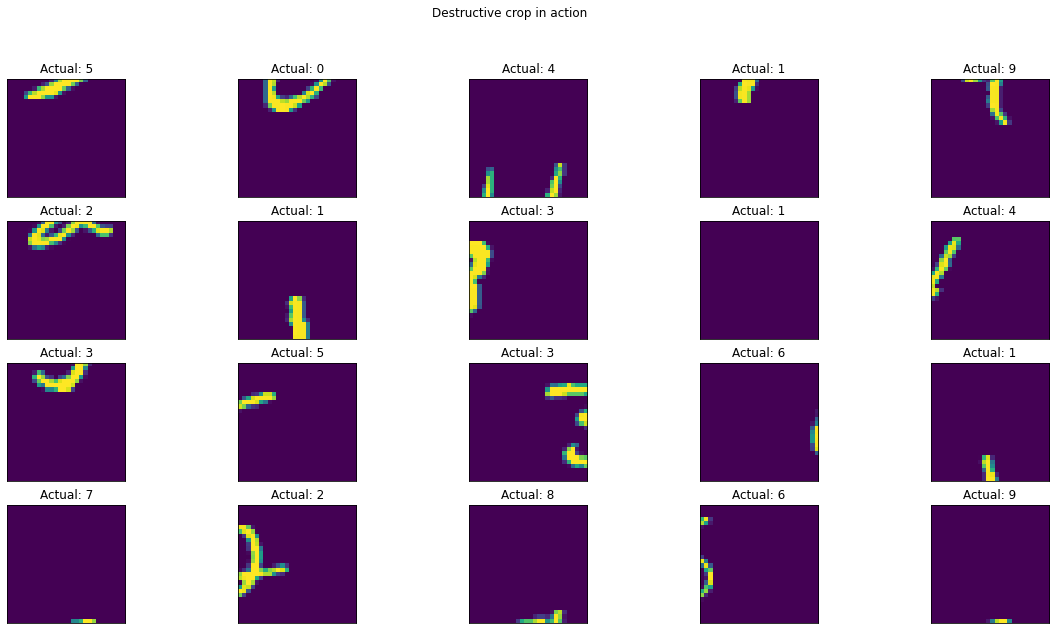

In [8]:
#plot destructive crop results 

noofitems = 20
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Destructive crop in action")
i = 1
for j in range(noofitems): 
  ax = fig.add_subplot(4, 5, i)
  ax.imshow(shifted_images[j])
  ax.title.set_text(f"Actual: {y_train[j]}")
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  i += 1

> Fit image and its bounding box functionality

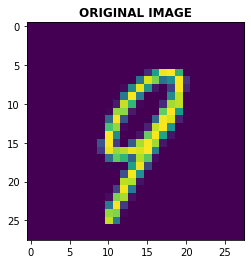

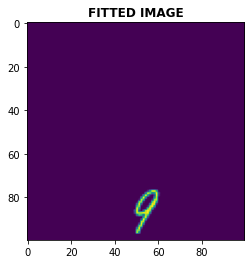

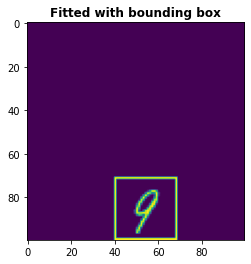

In [ ]:

indx = 22
original = x_train[indx]
plt.title("ORIGINAL IMAGE", fontweight="bold")
plt.imshow(original)
plt.show()
#showing the original image
a = np.zeros(shape=(100, 100))
plt.title("FITTED IMAGE", fontweight="bold")
a, pos = fit_image(a, original)
plt.imshow(a)
plt.show()
y, x = pos
a_rect = cv2.rectangle(a, (x, y), (x+28, y+28), (1.0, 1.0, 1.0), 1)
plt.title("Fitted with bounding box", fontweight="bold")
plt.imshow(a_rect)
plt.show()
#showing the transformed image

> * Larger destructive crop

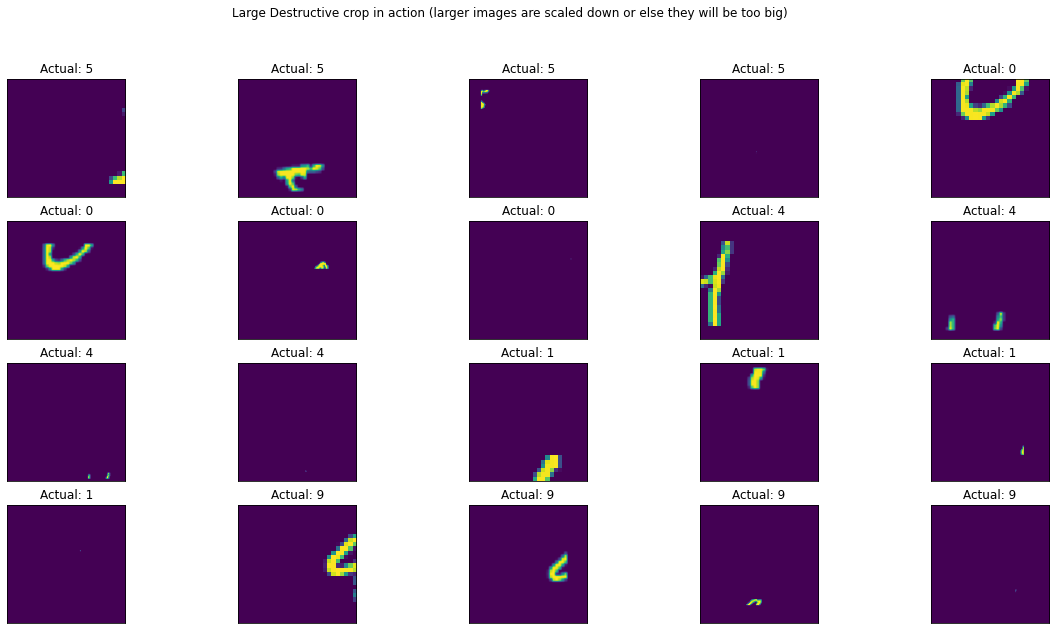

In [10]:
#test helper functions
Desired_sizes = [(28, 28), (40, 40), (100, 100), (1000, 1000)]
large_cropped = [larger_destructive_crop(digit, size) for digit in x_train[:5] for size in Desired_sizes]
noofitems = len(large_cropped) 
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Large Destructive crop in action (larger images are scaled down or else they will be too big)")
i = 1
for j in range(noofitems): 
  ax = fig.add_subplot(4, 5, i)
  ax.imshow(large_cropped[j])
  ax.title.set_text(f"Actual: {y_train[j//4]}")
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  i += 1

> * Create multiple digit data and plain display

In [13]:
mnist_256 = create_multiple_digit_data(100, 256, 2, x_train)

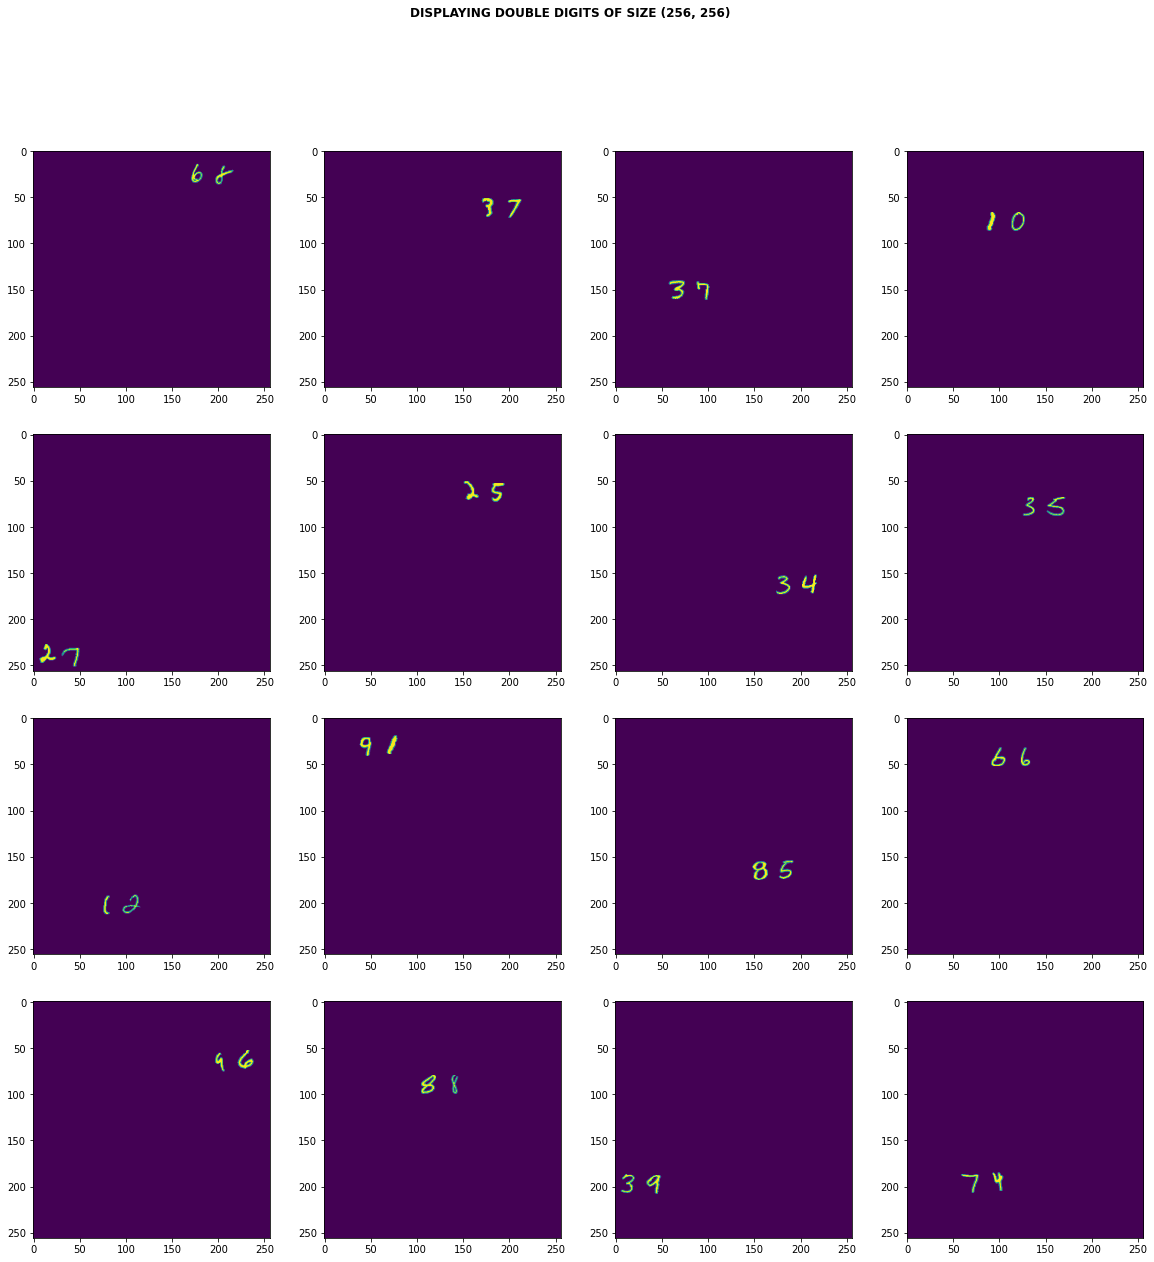

In [ ]:
#DISPLAY DOUBLE DIGIT MNIST SAMPLES
plain_display(mnist_256, "DISPLAYING DOUBLE DIGITS OF SIZE (256, 256)")

In [ ]:
mnist_256_3digit = create_multiple_digit_data(20, 256, 3, x_train)

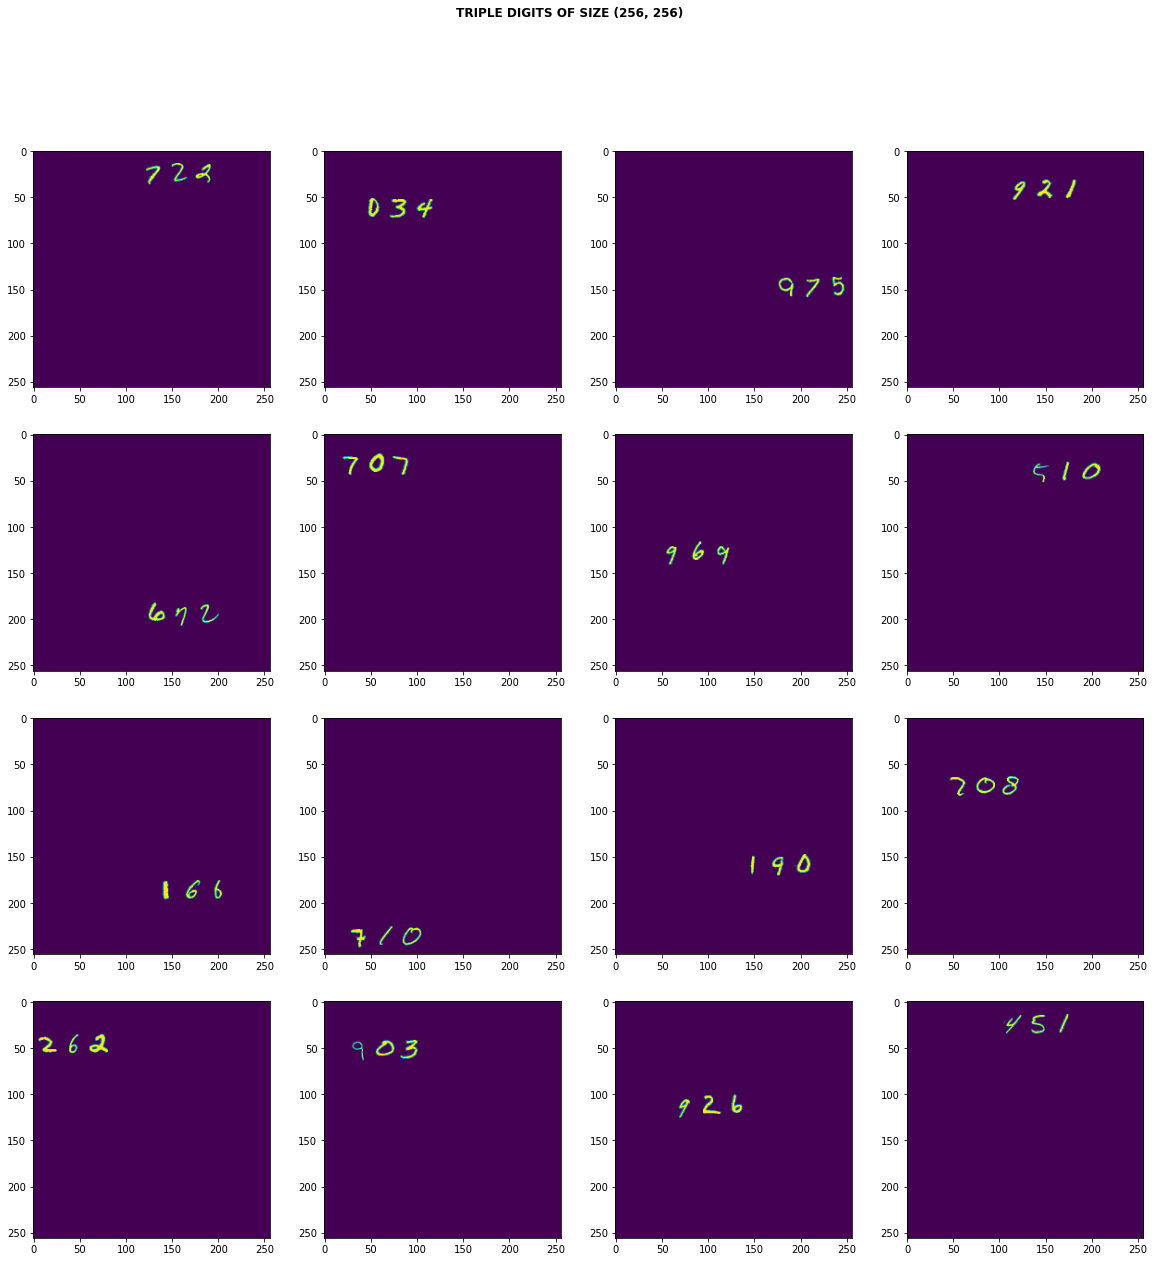

In [ ]:
plain_display(mnist_256_3digit, "TRIPLE DIGITS OF SIZE (256, 256)")

> * Slicer

3249


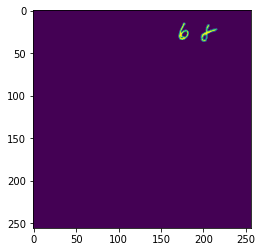

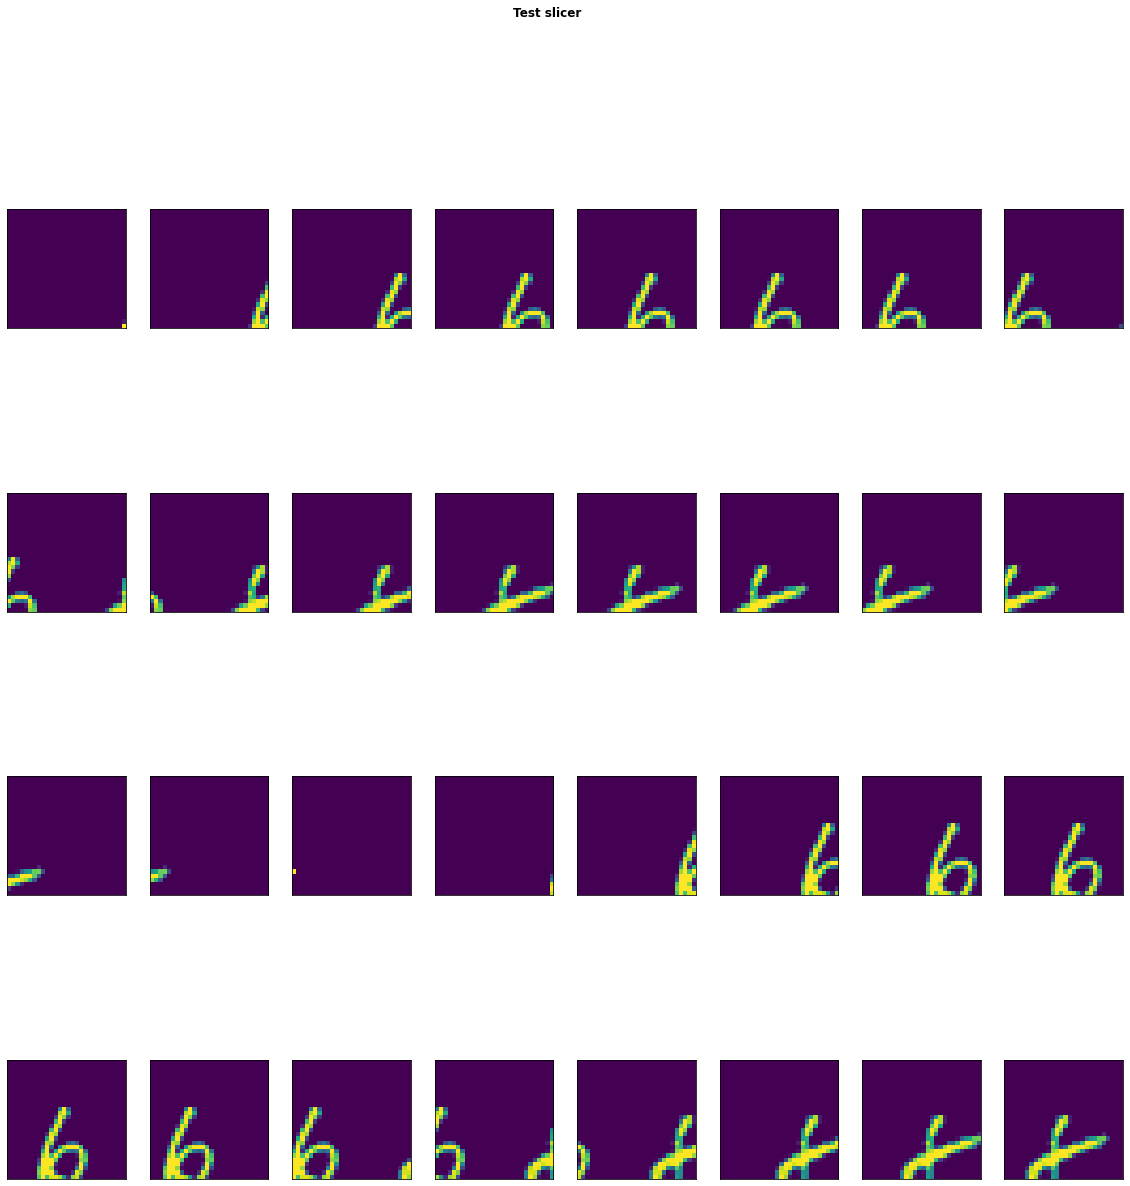

In [ ]:
testing_slicer = slicer(mnist_256[0], 4, 4)[0]
print(len(testing_slicer))
plt.imshow(mnist_256[0])
plt.show()
testing_slicer = [arr for arr in testing_slicer if np.array(arr).any() ]
plain_display(testing_slicer, "Test slicer", 32, tics=False)

> * hasDigit: checks if image has digit (uses model) and returns bounding boxes around it

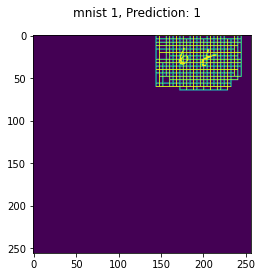

In [ ]:
#testing strider, WARNING: MODEL HAS NOT BEEN PROPERLY TRAINED YET. RESULT IS JUST TO SHOW FUNCTION WORKING.  
arr = copy.deepcopy(mnist_256[0])
pred, boxes = hasDigit(model_feeder, arr[np.newaxis, :, :], only_one=False)
for box in boxes: 
  y = box[0]
  x = box[1]
  arr = np.array(cv2.rectangle(arr, (x, y), (x+28, y+28), (1.0, 1.0, 1.0), 1))
  plt.imshow(arr)
  plt.suptitle(f"mnist 1, Prediction: {pred}")

Text(0.5, 0.98, 'mnist 1, Prediction: 1')

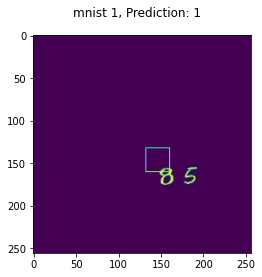

In [ ]:
#Draw one bouding box only around first match
arr = copy.deepcopy(mnist_256[10])
prediction, box = hasDigit(model_feeder, arr[np.newaxis, :, :], 12, 12)
y = box[0]
x = box[1]
arr = np.array(cv2.rectangle(arr, (x, y), (x+28, y+28), (1.0, 1.0, 1.0), 1))
plt.imshow(arr)

plt.suptitle(f"mnist 1, Prediction: {prediction}")

> * Detect Digits: detects digits and draws one bounding box around all detected digits

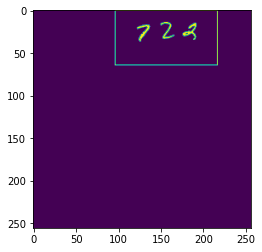

In [ ]:
pred, boxes = detect_digits(model_feeder, mnist_256_3digit[0])

> * Create Evaluation data: creates evaluation dataset, including labels of the given size

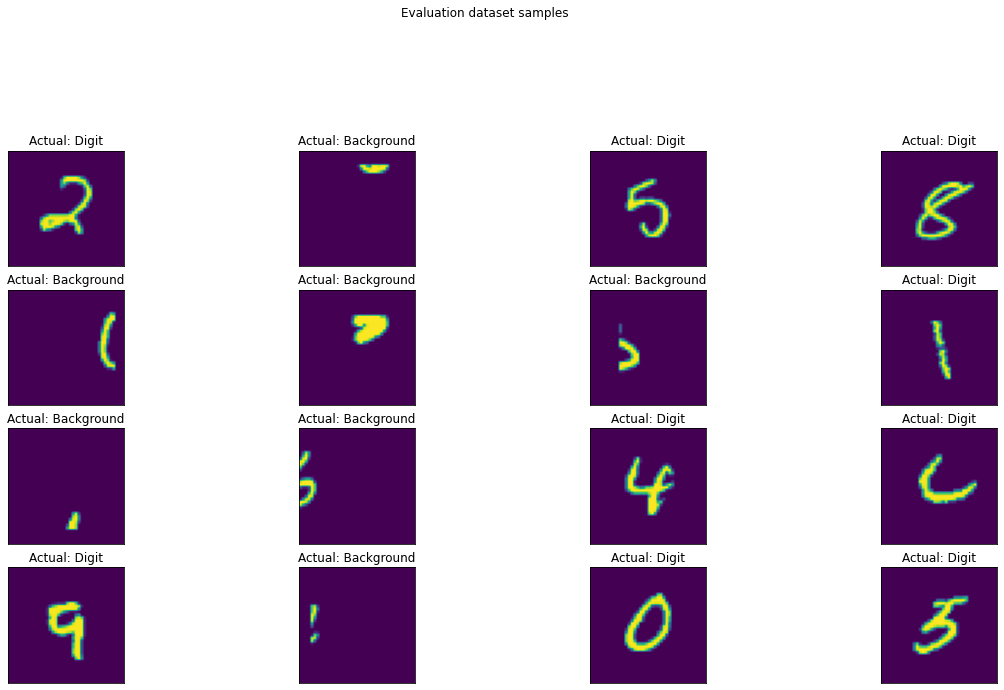

In [ ]:
newx_test, newy_test = create_evaluation_data(x_test, (40, 40))

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Evaluation dataset samples")
noofitems = 16 
i = 1
for j in range(noofitems): 
  ax = fig.add_subplot(8, 4, i)
  ax.imshow(newx_test[j])
  value = "Background" if newy_test[j] == 0 else "Digit"
  ax.title.set_text(f"Actual: {value}")
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  i += 1

# Integration Demonstrations; use functions together and display results

In [ ]:
#size of negatives = size of positives
#2/3 cropped, 1/3 empty
TOTAL_NEGATIVES = len(x_train)
NUM_CROPPED = TOTAL_NEGATIVES // 3 * 2
NUM_BLACK = TOTAL_NEGATIVES - NUM_CROPPED
negatives_tr = np.array([destructive_crop(x_train[i]) if i < NUM_CROPPED else black_img(x_train[i]) for i in range(TOTAL_NEGATIVES)])
negative_tr_labels = np.zeros(TOTAL_NEGATIVES)
newx_train = np.concatenate((x_train, negatives_tr))
newy_train = np.concatenate((np.ones(TOTAL_NEGATIVES), negative_tr_labels))

In [ ]:
#shuffle training data
tf.random.set_seed(5)
tf.random.shuffle(newx_train)
tf.random.set_seed(5)
tf.random.shuffle(newy_train)

#train our feeder model, improvement: shuffle data
model_feeder.fit(newx_train, newy_train, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.0029 - accuracy: 0.9997
Epoch 2/10
3750/3750 [==============================] - 9s 2ms/step - loss: 8.1595e-07 - accuracy: 1.0000
Epoch 3/10
3750/3750 [==============================] - 11s 3ms/step - loss: 8.8616e-08 - accuracy: 1.0000
Epoch 4/10
3750/3750 [==============================] - 9s 2ms/step - loss: 8.5393e-09 - accuracy: 1.0000
Epoch 5/10
3750/3750 [==============================] - 9s 2ms/step - loss: 7.1128e-10 - accuracy: 1.0000
Epoch 6/10
3750/3750 [==============================] - 9s 2ms/step - loss: 1.8676e-10 - accuracy: 1.0000
Epoch 7/10
3750/3750 [==============================] - 10s 3ms/step - loss: 7.0532e-11 - accuracy: 1.0000
Epoch 8/10
3750/3750 [==============================] - 9s 2ms/step - loss: 3.7750e-11 - accuracy: 1.0000
Epoch 9/10
3750/3750 [==============================] - 10s 3ms/step - loss: 2.4835e-11 - accuracy: 1.0000
Epoch 10/10
3750/3750 [========================

In [ ]:
x_test_feeder, y_test_feeder = create_evaluation_data(x_test, (28, 28))
results = model_feeder.evaluate(x_test_feeder, y_test_feeder)
print(results)

625/625 [==============================] - 1s 2ms/step - loss: 9.9539e-08 - accuracy: 1.0000
[9.953929236417025e-08, 1.0]


In [ ]:
noofitems = 16  
all_predictions = [hasDigit(model_feeder, arr[np.newaxis, :, :]) for arr in newx_test[:noofitems]]


[(1, (0, 8)), (0, None), (1, (0, 0)), (1, (0, 4)), (0, None), (1, (0, 4)), (1, (4, 0)), (1, (0, 4)), (0, None), (0, None), (1, (0, 4)), (1, (0, 0)), (1, (0, 0)), (0, None), (1, (0, 8)), (1, (0, 4))]


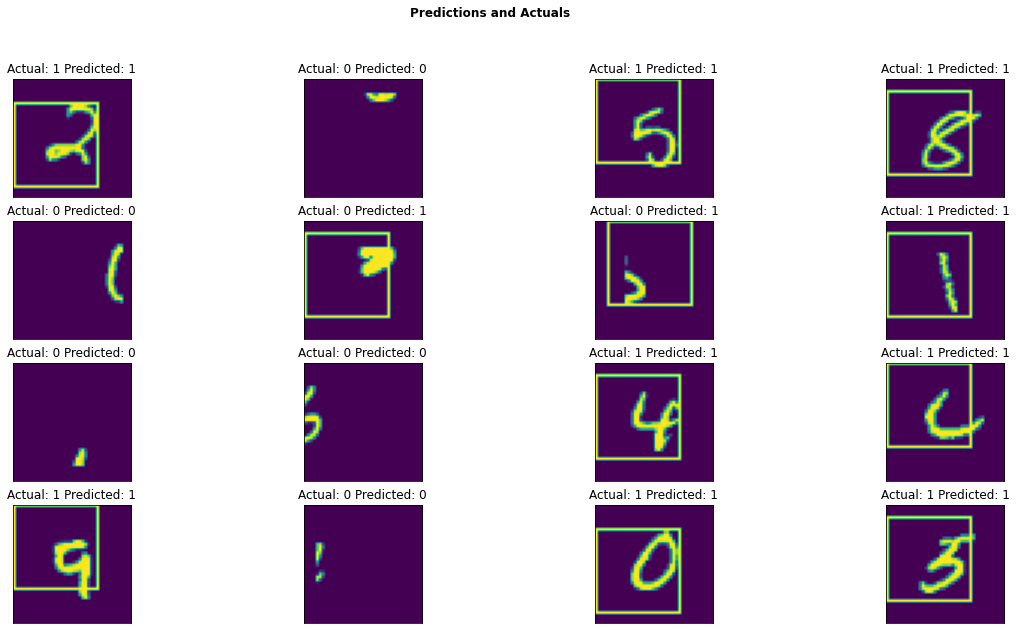

In [ ]:
import copy
predictions = copy.deepcopy(all_predictions[:noofitems])
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Predictions and Actuals", fontweight="bold")
i = 1
print(predictions)
for j in range(noofitems): 
  ax = fig.add_subplot(4, noofitems//4, i)
  image = newx_test[j]
  rect_loc = predictions[j][1]
  if rect_loc: 
    image = np.array(cv2.rectangle(image, (rect_loc[0], rect_loc[1]), (rect_loc[0]+28, rect_loc[1]+28), (1.0, 1.0, 1.0), 1))
  ax.imshow(image)
  ax.title.set_text(f"Actual: {int(newy_test[j])} Predicted: {predictions[j][0]}")
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  i += 1


In [ ]:
newx_test, newy_test = create_evaluation_data(x_test, (40, 40))

In [ ]:
#evaluating our strider on (40, 40) images, newx_test, newy_test relate to the 40 x 40 data
predictions = [hasDigit(model_feeder, arr[np.newaxis, :, :], 4, 4)[0] for arr in newx_test]

accuracy =   np.sum(predictions == newy_test) / len(newy_test)

In [ ]:
print(f" ACCURACY OF MODEL WITH (40, 40) IMAGES IS: {accuracy}")

 ACCURACY OF MODEL WITH (40, 40) IMAGES IS: 0.8396


In [ ]:
newx_test_256, newy_test_256 = create_evaluation_data(x_test[:len(x_test)//4], (256, 256))
predictions = [hasDigit(model_feeder, arr[np.newaxis, :, :], 4, 4)[0] for arr in newx_test_256]

accuracy = np.sum(predictions == newy_test_256) / len(newy_test_256)
print(f" ACCURACY OF MODEL WITH (256, 256) IMAGES IS: {accuracy}")


 ACCURACY OF MODEL WITH (256, 256) IMAGES IS: 0.5922


## Some Improvements: 
  Accuracy: 
- Increase variance of training data by rotating, resizing mnist data, increasing data size etc. 
- Use batch normalization/regularization
- overtrain and regularize/ train for more epochs
- Add Gaussian noise to training data
- Increase the depth of the NN
- Using other types of layers e.g CNN etc

Speed Improvements: 
- Prediction on large datasets by converting dataset to tf.dataset 
- Removing the dropout layer (useless lol)

<br>

<b> Parting Thought </b>: 
 Good assignment. Should definitely couple it with the mnist digit classifier to demonstrate how the entire pipeline works together and how the accuracy of the mnist digit classifier is improved. 
